In [1]:
from tools_stance import * 
from models import *
import torch 
import pandas as pd
import gc

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


dict_cl=dict()
dict_cl[0]="support"
dict_cl[1]="denying"
dict_cl[2]="questioning"
dict_cl[3]="commenting"

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

path="../../Datasets/CSV_Stance/"
train =pd.read_csv(path + "train_semeval_raw.csv")
val=pd.read_csv(path + "dev_semeval_raw.csv")
test=pd.read_csv(path + "test_semeval_raw.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


In [2]:
def cm_norma(matrix):
    return matrix/matrix.sum(axis=-1, keepdims=True)
    
    
def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq, trainPredict))
    """print ("")
    print ("------ Training ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq_v, trainPredict))
    """print ("")
    print ("------ Validation ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=cm_norma(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("------ Testing ------")
    print ("Accuracy", name_model, ": %.3f" % acc_t)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma_t)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [3]:
import os 
embeddings_index = {}
token_2_idx={}
idx_2_token={}
f = open(os.path.join("../../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
i=0
for line in f:
    values = line.split()
    if len(values)>200:
        word = values[0]
    else:
        #print ("Problema con line ", line)
        continue
    token_2_idx[word]=i
    idx_2_token[i]=word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Se encontraron 1193513 terminos con sus vectores de embedding.


In [4]:
MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
    
ids_train=train['Tw_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= np.asarray([1.0, 1.0, 1.0, 1.0])
print ("Pesos de clases:", class_weights)

ids_val=val['Tw_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['Tw_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

Pesos de clases: [1. 1. 1. 1.]


In [5]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1
    
x_val=np.zeros((shape_val[0], shape_val[1], emb))
i=0
for in_id in input_ids_val:
    x_val[i]=EMB_matrix[in_id]
    i+=1
    
x_test=np.zeros((shape_test[0], shape_test[1], emb))
i=0
for in_id in input_ids_test:
    x_test[i]=EMB_matrix[in_id]
    i+=1

In [6]:
def predecir_modelos(bs,predichos_all):  #best fit
    temp=predichos_all.copy()
    final=[np.argmax(pred) for pred in temp]  
    confianzas=[temp[i][final[i]] for i in range(len(final))]
    predichos_new=[]
    for i in range(len(temp)):
        indice=final[i]%4
        predichos_new.append(int(indice))
    return predichos_new,final,confianzas    

def predecir_modelos_norm(bs,predichos_all):  #normalizado
    temp=predichos_all.copy()
    final=[]
    confianzas=[]
    for pred in temp:   
        aux=np.ones(4)
        for i in range(1,6): #for machine pred
            sub=pred[(4*(i-1)):(4*i)]
            aux=aux*np.asarray(sub)
            
        aux=aux/np.sum(aux)
        final.append(np.argmax(aux))
        confianzas.append(aux[np.argmax(aux)])  
           
    predichos_new=[]
    for i in range(len(temp)):
        predichos_new.append(final[i])
    return predichos_new,final,confianzas
    
def predecir_modelos_average(bs,predichos_all): #average
    temp=predichos_all.copy()
    final=[]
    confianzas=[]
    for pred in temp:
        aux=np.zeros(4)
        for i in range(1,6):
            sub=pred[(4*(i-1)):(4*i)]
            aux=aux+np.asarray(sub)
            
        aux=aux/5.0 #dividido en el total de machines
        final.append(np.argmax(aux))
        confianzas.append(aux[np.argmax(aux)])  
           
    predichos_new=[]
    for i in range(len(temp)):
        predichos_new.append(final[i])
    return predichos_new,final,confianzas


# 0.0 No class weights

In [9]:
import matplotlib.pyplot as plt 

def eval_committe(mask, path, xfrom, xto, x_test, labels_test, bs=32):
    fs_macro_test={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    fs_none_test={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    accs_test={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    confusions_test={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

    best_test={'acc':[], 'none':[], 'macro':[], 'cm':[]}
    norm_test={'acc':[], 'none':[], 'macro':[], 'cm':[]}
    voting_test={'acc':[], 'none':[], 'macro':[], 'cm':[]}

    for j in range(xfrom, xto + 1):
        print ("")
        print ("---------------- EJECUCIÓN #"+str(j)+'----------------')
        cnn1= load_model(path+str(mask)+'/cnn1_'+str(j)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})  
        cnn2= load_model(path+str(mask)+'/cnn2_'+str(j)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()}) 
        rnn1= load_model(path+str(mask)+'/rnn1_'+str(j)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()}) 
        rnn2= load_model(path+str(mask)+'/rnn2_'+str(j)+'-exec.h5') 
        rnn3= load_model(path+str(mask)+'/rnn3_'+str(j)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()}) 

        list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
        index_models=np.arange(5)
        dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
        modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
        ind=np.arange(5)
        dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

        print ("Trabajando en predicciones Test")    
        for i in dict_trainedModel.keys(): 
            a_evaluar=dict_models[i]
            predicho=dict_trainedModel[i].predict(x_test, batch_size=bs)
            predicho=[np.argmax(pred) for pred in predicho]
            acc= accuracy_score(labels_test, predicho)  
            f1_ma=f1_score(labels_test, predicho, average='macro')
            f1_no=f1_score(labels_test, predicho, average=None)
            matriz=cm_norma(confusion_matrix(labels_test, predicho))
            fs_macro_test[dict_models[i]].append(f1_ma)
            fs_none_test[dict_models[i]].append(f1_no)
            accs_test[dict_models[i]].append(acc)
            confusions_test[dict_models[i]].append(matriz)

        predicciones_all_test=[]
        for i in dict_trainedModel.keys(): 
            a_evaluar=dict_models[i]
            predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))
        predichos_all_test=np.concatenate(np.asarray(predicciones_all_test),axis=-1)


        #print ("--------TESTING SET--------")

        print ("\nEvaluating Committee Best Fit...")
        trainPredicho, maxPredicho, confianzas = predecir_modelos(bs,predichos_all_test)
        acc_comite= accuracy_score(labels_test, trainPredicho)  
        print("Accuracy: %.3f" % acc_comite)
        f1=f1_score(labels_test, trainPredicho, average='macro') 
        print("F1-macro: %.3f" % f1)
        f1_no=f1_score(labels_test, trainPredicho, average=None)
        np.set_printoptions(precision=3)
        print("F1-score SDQC:",f1_no)
        cm=cm_norma(confusion_matrix(labels_test, trainPredicho))
        best_test['acc'].append(acc_comite)
        best_test['macro'].append(f1)
        best_test['none'].append(f1_no)
        best_test['cm'].append(cm)

        print ("\nEvaluating Committee Norm...")
        trainPredicho, maxPredicho, confianzas = predecir_modelos_norm(bs,predichos_all_test)
        acc_comite= accuracy_score(labels_test, trainPredicho)  
        print("Accuracy: %.3f" % acc_comite)
        f1=f1_score(labels_test, trainPredicho, average='macro') 
        print("F1-macro: %.3f" % f1)
        f1_no=f1_score(labels_test, trainPredicho, average=None) 
        np.set_printoptions(precision=3)
        print("F1-score SDQC:",f1_no)
        cm=cm_norma(confusion_matrix(labels_test, trainPredicho))
        norm_test['acc'].append(acc_comite)
        norm_test['macro'].append(f1)
        norm_test['none'].append(f1_no)
        norm_test['cm'].append(cm)
        
        print ("\nEvaluating Committee Voting...")
        trainPredicho, maxPredicho, confianzas = predecir_modelos_average(bs,predichos_all_test)
        acc_comite= accuracy_score(labels_test, trainPredicho)  
        print("Accuracy: %.3f" % acc_comite)
        f1=f1_score(labels_test, trainPredicho, average='macro') 
        print("F1-macro: %.3f" % f1)
        f1_no=f1_score(labels_test, trainPredicho, average=None) 
        np.set_printoptions(precision=3)
        print("F1-score SDQC:",f1_no)
        cm=cm_norma(confusion_matrix(labels_test, trainPredicho))
        voting_test['acc'].append(acc_comite)
        voting_test['macro'].append(f1)
        voting_test['none'].append(f1_no)
        voting_test['cm'].append(cm)
        
        keras.backend.clear_session()
        gc.collect()

    return best_test, norm_test, voting_test

def plot_cm(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    thresh = cm.max() / 2.# if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

In [10]:
ruta= '../../Datasets/Models_Stance/'
best_test, norm_test, voting_test  = eval_committe('0.0', ruta, 1, 20, x_test, labels_test)


---------------- EJECUCIÓN #1----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.642
F1-macro: 0.308
F1-score SDQC: [0.026 0.027 0.406 0.771]

Evaluating Committee Norm...
Accuracy: 0.784
F1-macro: 0.376
F1-score SDQC: [0.026 0.028 0.579 0.873]

Evaluating Committee Voting...
Accuracy: 0.786
F1-macro: 0.383
F1-score SDQC: [0.026 0.028 0.604 0.874]

---------------- EJECUCIÓN #2----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.766
F1-macro: 0.431
F1-score SDQC: [0.222 0.08  0.559 0.862]

Evaluating Committee Norm...
Accuracy: 0.765
F1-macro: 0.380
F1-score SDQC: [0.113 0.    0.544 0.861]

Evaluating Committee Voting...
Accuracy: 0.765
F1-macro: 0.373
F1-score SDQC: [0.097 0.    0.533 0.862]

---------------- EJECUCIÓN #3----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.776
F1-macro: 0.416
F1-score SDQC: [0.067 0.127 0.603 0.868]

Evaluating Committee Norm

[TEST] Acc Best comité: 0.742  -- std: 0.036
[TEST] F1 macro Best comité: 0.403  -- std: 0.035
[TEST] F1-score NIPS Best comité: [0.136 0.086 0.547 0.844]


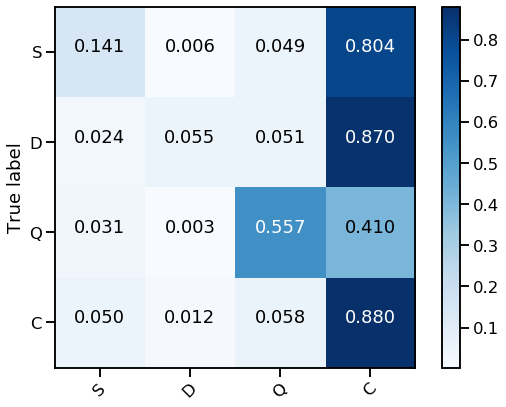

In [12]:
print ("[TEST] Acc Best comité: %.3f" % np.mean(np.asarray(best_test['acc'])), " -- std: %.3f" % np.std(np.asarray(best_test['acc'])))
print ("[TEST] F1 macro Best comité: %.3f" % np.mean(np.asarray(best_test['macro'])), " -- std: %.3f" % np.std(np.asarray(best_test['macro'])))
temp=np.zeros(4)
for result in best_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score NIPS Best comité:" ,temp/x)

cm=np.zeros((4,4))
for result in best_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='Blues')


[TEST] Acc Best comité: 0.768  -- std: 0.015
[TEST] F1 macro Best comité: 0.373  -- std: 0.028
[TEST] F1-score NIPS Best comité: [0.1   0.017 0.51  0.864]


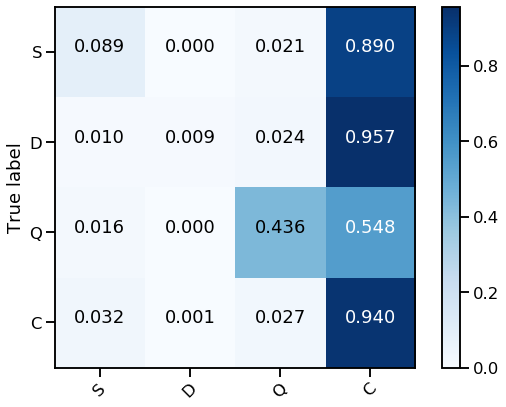

In [13]:
print ("[TEST] Acc Best comité: %.3f" % np.mean(np.asarray(norm_test['acc'])), " -- std: %.3f" % np.std(np.asarray(norm_test['acc'])))
print ("[TEST] F1 macro Best comité: %.3f" % np.mean(np.asarray(norm_test['macro'])), " -- std: %.3f" % np.std(np.asarray(norm_test['macro'])))
temp=np.zeros(4)
for result in norm_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score NIPS Best comité:" ,temp/x)

cm=np.zeros((4,4))
for result in norm_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='Blues')


[TEST] Acc Best comité: 0.770  -- std: 0.013
[TEST] F1 macro Best comité: 0.381  -- std: 0.024
[TEST] F1-score NIPS Best comité: [0.096 0.019 0.543 0.864]


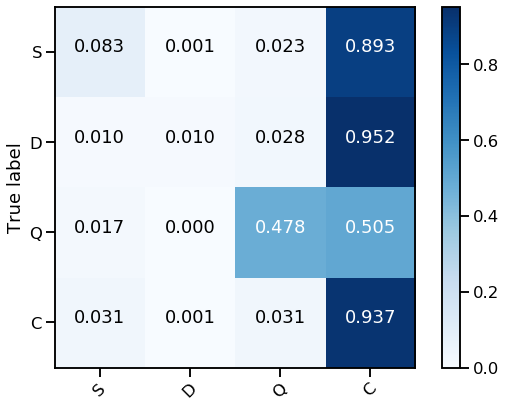

In [14]:

print ("[TEST] Acc Best comité: %.3f" % np.mean(np.asarray(voting_test['acc'])), " -- std: %.3f" % np.std(np.asarray(voting_test['acc'])))
print ("[TEST] F1 macro Best comité: %.3f" % np.mean(np.asarray(voting_test['macro'])), " -- std: %.3f" % np.std(np.asarray(voting_test['macro'])))
temp=np.zeros(4)
for result in voting_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score NIPS Best comité:" ,temp/x)

cm=np.zeros((4,4))
for result in voting_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='Blues')


## 0.0 Class Weights

In [15]:
best_test, norm_test, voting_test  = eval_committe('0.0cw', ruta, 1, 20, x_test, labels_test)


---------------- EJECUCIÓN #1----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.623
F1-macro: 0.444
F1-score SDQC: [0.233 0.264 0.538 0.742]

Evaluating Committee Norm...
Accuracy: 0.696
F1-macro: 0.488
F1-score SDQC: [0.271 0.273 0.604 0.805]

Evaluating Committee Voting...
Accuracy: 0.684
F1-macro: 0.485
F1-score SDQC: [0.27  0.267 0.612 0.792]

---------------- EJECUCIÓN #2----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.657
F1-macro: 0.427
F1-score SDQC: [0.241 0.226 0.461 0.78 ]

Evaluating Committee Norm...
Accuracy: 0.703
F1-macro: 0.471
F1-score SDQC: [0.24  0.252 0.583 0.811]

Evaluating Committee Voting...
Accuracy: 0.694
F1-macro: 0.468
F1-score SDQC: [0.243 0.258 0.565 0.804]

---------------- EJECUCIÓN #3----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.693
F1-macro: 0.456
F1-score SDQC: [0.248 0.168 0.602 0.805]

Evaluating Committee Norm

[TEST] Acc Best comité: 0.697  -- std: 0.044
[TEST] F1 macro Best comité: 0.432  -- std: 0.023
[TEST] F1-score SDQC Best comité: [0.18  0.185 0.557 0.808]


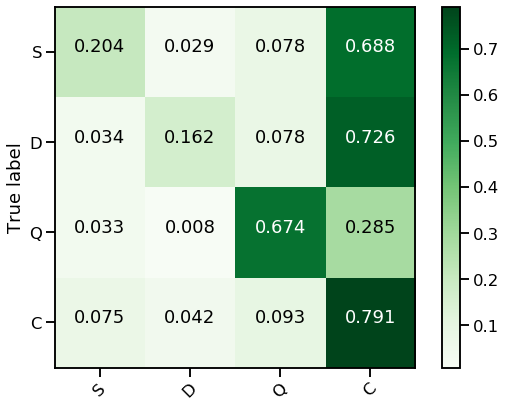

[TEST] Acc Norm comité: 0.719  -- std: 0.020
[TEST] F1 macro Norm comité: 0.459  -- std: 0.020
[TEST] F1-score SDQC Norm comité: [0.195 0.199 0.621 0.823]


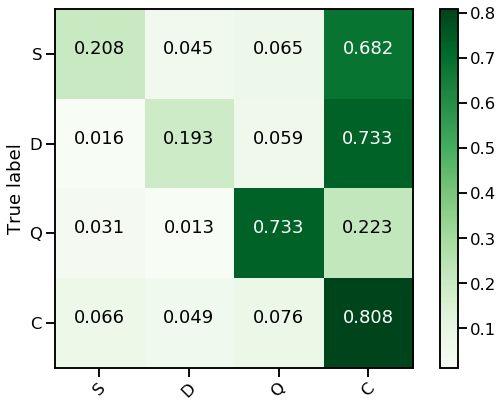

[TEST] Acc Voting comité: 0.710  -- std: 0.021
[TEST] F1 macro Voting comité: 0.457  -- std: 0.021
[TEST] F1-score SDQC Voting comité: [0.198 0.202 0.614 0.816]


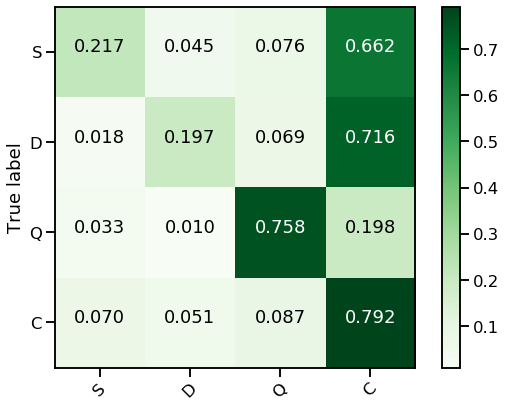

In [17]:
x=20.0

print ("[TEST] Acc Best comité: %.3f" % np.mean(np.asarray(best_test['acc'])), " -- std: %.3f" % np.std(np.asarray(best_test['acc'])))
print ("[TEST] F1 macro Best comité: %.3f" % np.mean(np.asarray(best_test['macro'])), " -- std: %.3f" % np.std(np.asarray(best_test['macro'])))
temp=np.zeros(4)
for result in best_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score SDQC Best comité:" ,temp/x)

cm=np.zeros((4,4))
for result in best_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='Greens')

print ("[TEST] Acc Norm comité: %.3f" % np.mean(np.asarray(norm_test['acc'])), " -- std: %.3f" % np.std(np.asarray(norm_test['acc'])))
print ("[TEST] F1 macro Norm comité: %.3f" % np.mean(np.asarray(norm_test['macro'])), " -- std: %.3f" % np.std(np.asarray(norm_test['macro'])))
temp=np.zeros(4)
for result in norm_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score SDQC Norm comité:" ,temp/x)

cm=np.zeros((4,4))
for result in norm_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='Greens')


print ("[TEST] Acc Voting comité: %.3f" % np.mean(np.asarray(voting_test['acc'])), " -- std: %.3f" % np.std(np.asarray(voting_test['acc'])))
print ("[TEST] F1 macro Voting comité: %.3f" % np.mean(np.asarray(voting_test['macro'])), " -- std: %.3f" % np.std(np.asarray(voting_test['macro'])))
temp=np.zeros(4)
for result in voting_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score SDQC Voting comité:" ,temp/x)

cm=np.zeros((4,4))
for result in voting_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='Greens')

## 0.15 Balanced

In [18]:
best_test, norm_test, voting_test  = eval_committe('0.15', ruta, 1, 20, x_test, labels_test)


---------------- EJECUCIÓN #1----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.658
F1-macro: 0.448
F1-score SDQC: [0.232 0.212 0.564 0.784]

Evaluating Committee Norm...
Accuracy: 0.688
F1-macro: 0.471
F1-score SDQC: [0.24  0.204 0.64  0.801]

Evaluating Committee Voting...
Accuracy: 0.677
F1-macro: 0.467
F1-score SDQC: [0.235 0.213 0.628 0.792]

---------------- EJECUCIÓN #2----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.601
F1-macro: 0.410
F1-score SDQC: [0.187 0.27  0.446 0.738]

Evaluating Committee Norm...
Accuracy: 0.696
F1-macro: 0.475
F1-score SDQC: [0.251 0.243 0.598 0.809]

Evaluating Committee Voting...
Accuracy: 0.677
F1-macro: 0.474
F1-score SDQC: [0.246 0.25  0.609 0.792]

---------------- EJECUCIÓN #3----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.604
F1-macro: 0.433
F1-score SDQC: [0.229 0.232 0.539 0.731]

Evaluating Committee Norm

[TEST] Acc Best comité: 0.573  -- std: 0.062
[TEST] F1 macro Best comité: 0.409  -- std: 0.034
[TEST] F1-score SDQC Best comité: [0.188 0.228 0.519 0.701]


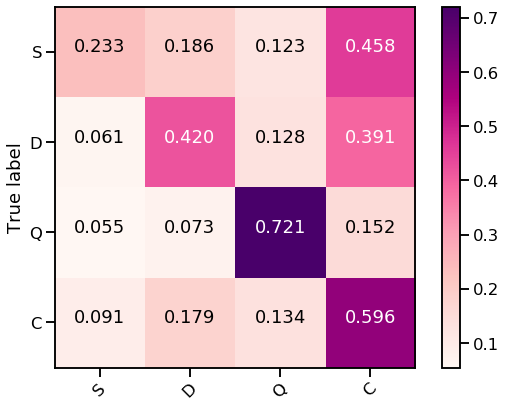

[TEST] Acc Norm comité: 0.668  -- std: 0.033
[TEST] F1 macro Norm comité: 0.464  -- std: 0.021
[TEST] F1-score SDQC Norm comité: [0.211 0.255 0.607 0.784]


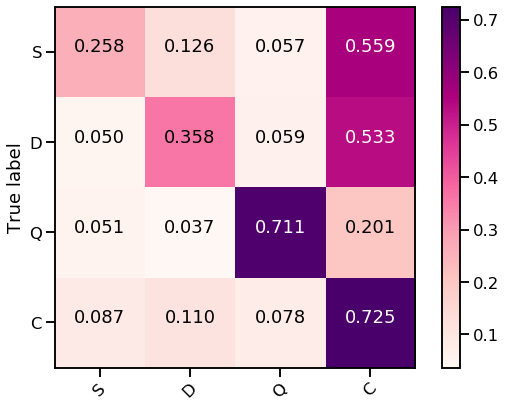

[TEST] Acc Voting comité: 0.644  -- std: 0.043
[TEST] F1 macro Voting comité: 0.453  -- std: 0.024
[TEST] F1-score SDQC Voting comité: [0.206 0.247 0.595 0.763]


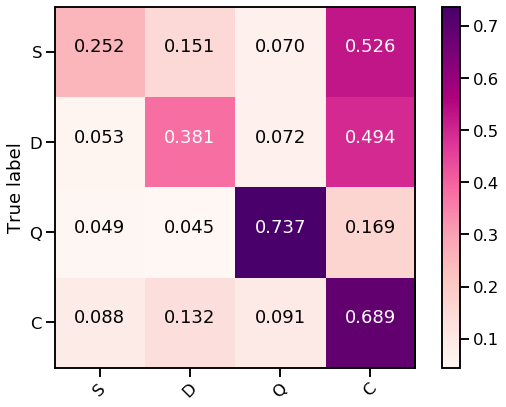

In [19]:
x=20.0

print ("[TEST] Acc Best comité: %.3f" % np.mean(np.asarray(best_test['acc'])), " -- std: %.3f" % np.std(np.asarray(best_test['acc'])))
print ("[TEST] F1 macro Best comité: %.3f" % np.mean(np.asarray(best_test['macro'])), " -- std: %.3f" % np.std(np.asarray(best_test['macro'])))
temp=np.zeros(4)
for result in best_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score SDQC Best comité:" ,temp/x)

cm=np.zeros((4,4))
for result in best_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='RdPu')

print ("[TEST] Acc Norm comité: %.3f" % np.mean(np.asarray(norm_test['acc'])), " -- std: %.3f" % np.std(np.asarray(norm_test['acc'])))
print ("[TEST] F1 macro Norm comité: %.3f" % np.mean(np.asarray(norm_test['macro'])), " -- std: %.3f" % np.std(np.asarray(norm_test['macro'])))
temp=np.zeros(4)
for result in norm_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score SDQC Norm comité:" ,temp/x)

cm=np.zeros((4,4))
for result in norm_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='RdPu')


print ("[TEST] Acc Voting comité: %.3f" % np.mean(np.asarray(voting_test['acc'])), " -- std: %.3f" % np.std(np.asarray(voting_test['acc'])))
print ("[TEST] F1 macro Voting comité: %.3f" % np.mean(np.asarray(voting_test['macro'])), " -- std: %.3f" % np.std(np.asarray(voting_test['macro'])))
temp=np.zeros(4)
for result in voting_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score SDQC Voting comité:" ,temp/x)

cm=np.zeros((4,4))
for result in voting_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='RdPu')


## 50% De 1 - 20

In [20]:
best_test, norm_test, voting_test  = eval_committe('0.5', ruta, 1, 20, x_test, labels_test)


---------------- EJECUCIÓN #1----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.583
F1-macro: 0.428
F1-score SDQC: [0.238 0.236 0.533 0.706]

Evaluating Committee Norm...
Accuracy: 0.646
F1-macro: 0.451
F1-score SDQC: [0.188 0.255 0.597 0.763]

Evaluating Committee Voting...
Accuracy: 0.639
F1-macro: 0.446
F1-score SDQC: [0.2   0.246 0.58  0.758]

---------------- EJECUCIÓN #2----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.647
F1-macro: 0.419
F1-score SDQC: [0.105 0.254 0.54  0.776]

Evaluating Committee Norm...
Accuracy: 0.689
F1-macro: 0.446
F1-score SDQC: [0.116 0.245 0.618 0.804]

Evaluating Committee Voting...
Accuracy: 0.681
F1-macro: 0.449
F1-score SDQC: [0.112 0.251 0.637 0.797]

---------------- EJECUCIÓN #3----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.550
F1-macro: 0.363
F1-score SDQC: [0.065 0.276 0.435 0.679]

Evaluating Committee Norm

[TEST] Acc Best comité: 0.519  -- std: 0.095
[TEST] F1 macro Best comité: 0.380  -- std: 0.044
[TEST] F1-score SDQC Best comité: [0.157 0.222 0.503 0.636]


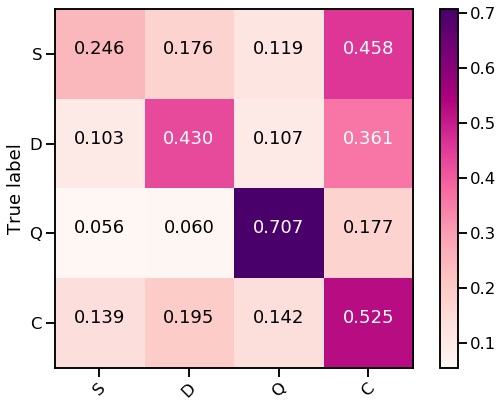

[TEST] Acc Norm comité: 0.621  -- std: 0.058
[TEST] F1 macro Norm comité: 0.433  -- std: 0.021
[TEST] F1-score SDQC Norm comité: [0.162 0.233 0.597 0.74 ]


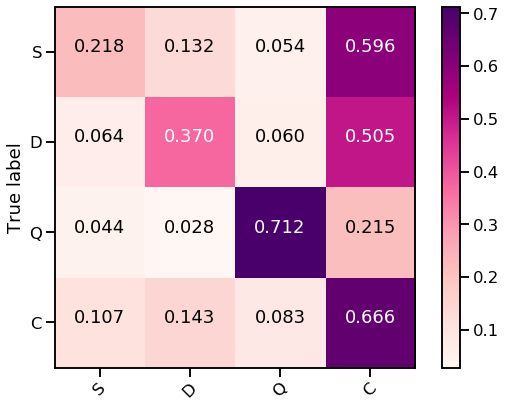

[TEST] Acc Voting comité: 0.602  -- std: 0.057
[TEST] F1 macro Voting comité: 0.425  -- std: 0.023
[TEST] F1-score SDQC Voting comité: [0.167 0.232 0.58  0.723]


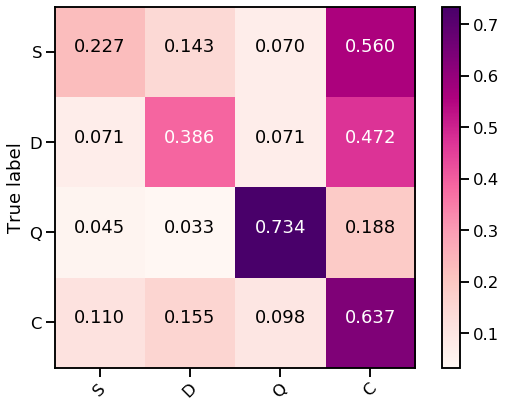

In [21]:
x=20.0

print ("[TEST] Acc Best comité: %.3f" % np.mean(np.asarray(best_test['acc'])), " -- std: %.3f" % np.std(np.asarray(best_test['acc'])))
print ("[TEST] F1 macro Best comité: %.3f" % np.mean(np.asarray(best_test['macro'])), " -- std: %.3f" % np.std(np.asarray(best_test['macro'])))
temp=np.zeros(4)
for result in best_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score SDQC Best comité:" ,temp/x)

cm=np.zeros((4,4))
for result in best_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='RdPu')

print ("[TEST] Acc Norm comité: %.3f" % np.mean(np.asarray(norm_test['acc'])), " -- std: %.3f" % np.std(np.asarray(norm_test['acc'])))
print ("[TEST] F1 macro Norm comité: %.3f" % np.mean(np.asarray(norm_test['macro'])), " -- std: %.3f" % np.std(np.asarray(norm_test['macro'])))
temp=np.zeros(4)
for result in norm_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score SDQC Norm comité:" ,temp/x)

cm=np.zeros((4,4))
for result in norm_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='RdPu')


print ("[TEST] Acc Voting comité: %.3f" % np.mean(np.asarray(voting_test['acc'])), " -- std: %.3f" % np.std(np.asarray(voting_test['acc'])))
print ("[TEST] F1 macro Voting comité: %.3f" % np.mean(np.asarray(voting_test['macro'])), " -- std: %.3f" % np.std(np.asarray(voting_test['macro'])))
temp=np.zeros(4)
for result in voting_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score SDQC Voting comité:" ,temp/x)

cm=np.zeros((4,4))
for result in voting_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='RdPu')


## 85% De 1 - 10

In [22]:
best_test, norm_test, voting_test  = eval_committe('0.85', ruta, 1, 10, x_test, labels_test)


---------------- EJECUCIÓN #1----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.606
F1-macro: 0.393
F1-score SDQC: [0.154 0.184 0.496 0.736]

Evaluating Committee Norm...
Accuracy: 0.647
F1-macro: 0.404
F1-score SDQC: [0.138 0.131 0.575 0.771]

Evaluating Committee Voting...
Accuracy: 0.642
F1-macro: 0.406
F1-score SDQC: [0.136 0.158 0.566 0.766]

---------------- EJECUCIÓN #2----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.548
F1-macro: 0.370
F1-score SDQC: [0.103 0.186 0.491 0.701]

Evaluating Committee Norm...
Accuracy: 0.626
F1-macro: 0.394
F1-score SDQC: [0.106 0.21  0.497 0.763]

Evaluating Committee Voting...
Accuracy: 0.611
F1-macro: 0.392
F1-score SDQC: [0.108 0.198 0.514 0.751]

---------------- EJECUCIÓN #3----------------
Trabajando en predicciones Test

Evaluating Committee Best Fit...
Accuracy: 0.573
F1-macro: 0.352
F1-score SDQC: [0.038 0.165 0.494 0.712]

Evaluating Committee Norm

[TEST] Acc Best comité: 0.583  -- std: 0.055
[TEST] F1 macro Best comité: 0.373  -- std: 0.013
[TEST] F1-score SDQC Best comité: [0.059 0.089 0.239 0.359]


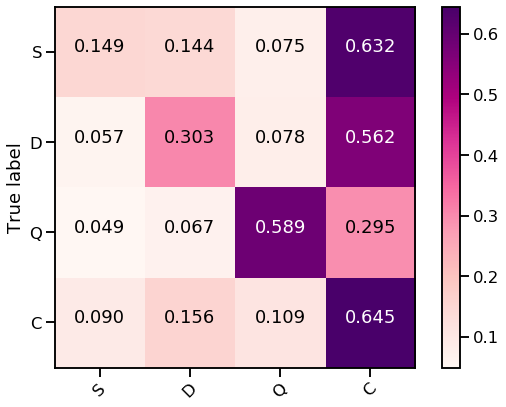

[TEST] Acc Norm comité: 0.645  -- std: 0.052
[TEST] F1 macro Norm comité: 0.405  -- std: 0.010
[TEST] F1-score SDQC Norm comité: [0.061 0.092 0.272 0.384]


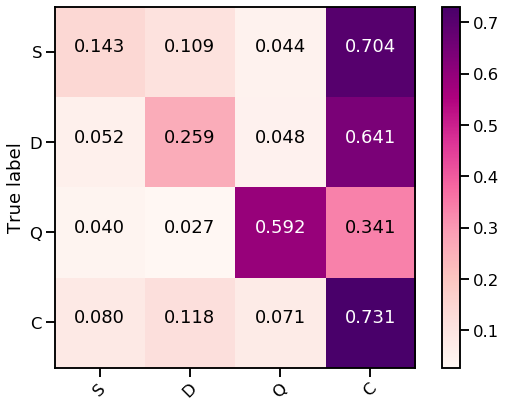

[TEST] Acc Voting comité: 0.638  -- std: 0.049
[TEST] F1 macro Voting comité: 0.404  -- std: 0.011
[TEST] F1-score SDQC Voting comité: [0.06  0.096 0.271 0.381]


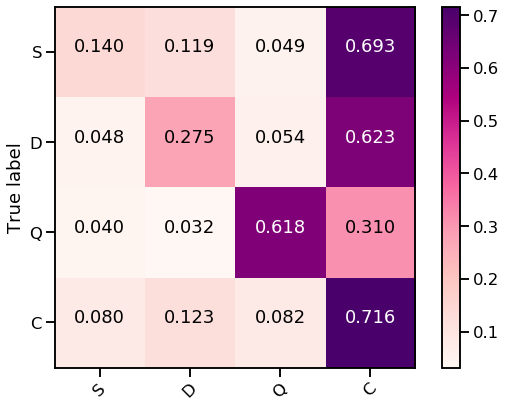

In [23]:
x=20.0

print ("[TEST] Acc Best comité: %.3f" % np.mean(np.asarray(best_test['acc'])), " -- std: %.3f" % np.std(np.asarray(best_test['acc'])))
print ("[TEST] F1 macro Best comité: %.3f" % np.mean(np.asarray(best_test['macro'])), " -- std: %.3f" % np.std(np.asarray(best_test['macro'])))
temp=np.zeros(4)
for result in best_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score SDQC Best comité:" ,temp/x)

cm=np.zeros((4,4))
for result in best_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='RdPu')

print ("[TEST] Acc Norm comité: %.3f" % np.mean(np.asarray(norm_test['acc'])), " -- std: %.3f" % np.std(np.asarray(norm_test['acc'])))
print ("[TEST] F1 macro Norm comité: %.3f" % np.mean(np.asarray(norm_test['macro'])), " -- std: %.3f" % np.std(np.asarray(norm_test['macro'])))
temp=np.zeros(4)
for result in norm_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score SDQC Norm comité:" ,temp/x)

cm=np.zeros((4,4))
for result in norm_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='RdPu')


print ("[TEST] Acc Voting comité: %.3f" % np.mean(np.asarray(voting_test['acc'])), " -- std: %.3f" % np.std(np.asarray(voting_test['acc'])))
print ("[TEST] F1 macro Voting comité: %.3f" % np.mean(np.asarray(voting_test['macro'])), " -- std: %.3f" % np.std(np.asarray(voting_test['macro'])))
temp=np.zeros(4)
for result in voting_test['none']:
    temp+=result
np.set_printoptions(precision=3)
print ("[TEST] F1-score SDQC Voting comité:" ,temp/x)

cm=np.zeros((4,4))
for result in voting_test['cm']:
    cm+=result
plot_cm(cm_norma(cm), ['S', 'D', 'Q', 'C'], title='', cmap='RdPu')
